## Imports

In [27]:
import argparse
import logging
import numpy as np
import pandas as pd
import random
import sys
import warnings
from datetime import datetime
from pathlib import Path
import os
import pickle
from meta_heuristic.TaskGraph import TaskGraph

warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt

plt.rcParams.update({
    'font.size': 28,            # Base font size
    'axes.titlesize': 36,       # Title of the axes
    'axes.labelsize': 24,       # Labels of the axes
    'xtick.labelsize': 20,      # X-axis tick labels
    'ytick.labelsize': 20,      # Y-axis tick labels
    #'legend.fontsize': 18,      # Legend font size
    'figure.titlesize': 40      # Figure title font size
})

lgd_params = {'hlen':1,'bpad':0.2,'lspace':0.2,'htxtpad':0.2,'baxpad':0.2,'cspace':0.2,'ncol':1,'ecolor':'black','size':24,'alpha':0.2}

algorithm_names = []
estimated_objective = []
makespans = []


In [28]:
area_constraint = 0.9
graph_name = 'test-data/01_tosa.dot'
hw_scale = 0.3
hw_scale_variance = 0.5
comm_scale_factor = 1.0

In [29]:
TG = TaskGraph(area_constraint=area_constraint)
TG.load_graph_from_pydot(
    graph_name,
    k=hw_scale,
    l=hw_scale_variance,
    mu=comm_scale_factor,
    A_max=100,seed=42
)



2025-07-17 20:28:04,513 - __main__ - INFO - TaskGraph initialized with area constraint: 0.900000
2025-07-17 20:28:05,791 - __main__ - INFO - Loaded graph from test-data/01_tosa.dot with 175 nodes
2025-07-17 20:28:05,793 - __main__ - INFO - Graph initialized with total area: 9282.930925823566


## Vanilla PSO

In [30]:
%%time
import pyswarms as ps

# Set-up hyperparameters
options = {'c1': 1.05, 'c2': 0.1, 'w': 1.525}

# Call instance of PSO
optimizer = ps.single.GlobalBestPSO(n_particles=50, dimensions=len(TG.graph.nodes()), options=options,ftol=1e-3,ftol_iter=10)

# Perform optimization
cost, pos = optimizer.optimize(TG.evaluation_from_swarm, iters=100,verbose=True)
print(cost)

assignment = TG.get_partitioning(pos)
result = TG.get_makespan(assignment)
print(result['makespan'])

algorithm_names.append('vanilla-pso')
estimated_objective.append(cost)
makespans.append(result['makespan'])

2025-07-17 20:30:14,068 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 1.05, 'c2': 0.1, 'w': 1.525}
pyswarms.single.global_best:  29%|█████████████████████▏                                                   |29/100, best_cost=6.19e+3
2025-07-17 20:30:14,701 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 6192.7764349752515


6192.7764349752515
4999.059646834427
CPU times: user 659 ms, sys: 7.97 ms, total: 667 ms
Wall time: 663 ms


## Discrete binary PSO

In [31]:
my_options = {'c1': 1.05, 'c2': 0.1, 'w': 1.525,'k':4,'p':2}
my_swarm = ps.discrete.binary.BinaryPSO(n_particles=50, dimensions=len(TG.graph.nodes()), options=my_options,ftol=1e-3,ftol_iter=50)

cost, pos = my_swarm.optimize(TG.evaluate_from_random, iters=100,verbose=True)
print(cost)

assignment = TG.get_partitioning(pos)
result = TG.get_makespan(assignment)
print(result['makespan'])

algorithm_names.append('DB-pso')
estimated_objective.append(cost)
makespans.append(result['makespan'])

2025-07-17 20:31:01,784 - pyswarms.discrete.binary - INFO - Optimize for 100 iters with {'c1': 1.05, 'c2': 0.1, 'w': 1.525, 'k': 4, 'p': 2}
pyswarms.discrete.binary:  55%|█████████████████████████████████████████▊                                  |55/100, best_cost=6.01e+3
2025-07-17 20:31:06,552 - pyswarms.discrete.binary - INFO - Optimization finished | best cost: 6010.284411385389


6010.284411385389
4458.639978294757


## Pypop library test

### LMMAES

In [32]:
# LMMAES: Limited Memory Matrix Adaptation Evolution Strategy
from pypop7.optimizers.es.lmmaes import LMMAES

ndim_problem = len(TG.graph.nodes())
problem = {'fitness_function': TG.evaluate_from_singlepoint,  # fitness function corresponding to the problem
           'ndim_problem': ndim_problem,  # number of dimension of the problem to be optimized
           'lower_boundary': 0.0 * np.ones((ndim_problem,)),  # lower boundary of search range
           'upper_boundary': 1.0 * np.ones((ndim_problem,))}  # upper boundary of search range

# to define algorithm options (which differ in details among different optimizers)
options = {'fitness_threshold': 1e-10,  # to stop if best-so-far fitness <= 1e-10
           'max_function_evaluations': 40000,  # to stop if iteration exists seed
           'seed_rng': 0,  # random seed (which should be set for repeatability)
           'x': 0.5 * np.ones((ndim_problem,)),  # mean of search distribution
           'sigma': 0.1,  # global step-size (but not necessarily optimal)
           'verbose': 500}
lmmaes = LMMAES(problem, options)  # to initialize (under a unified API)
results = lmmaes.optimize()  # to run its (time-consuming) evolution process
#print(results)

#print('proxy estimation',results['best_so_far_y'])
assignment = TG.get_partitioning(results['best_so_far_x'])
result = TG.get_makespan(assignment)
print(result['makespan'])

algorithm_names.append('LMMAES')
estimated_objective.append(results['best_so_far_y'])
makespans.append(result['makespan'])

  * Generation 0: best_so_far_y 1.57205e+04, min(y) 1.57205e+04 & Evaluations 19
  * Generation 500: best_so_far_y 6.51611e+03, min(y) 6.51611e+03 & Evaluations 9519
  * Generation 590: best_so_far_y 6.51611e+03, min(y) 6.51611e+03 & Evaluations 11210
 ....... *** restart *** .......
  * Generation 0: best_so_far_y 6.51611e+03, min(y) 1.53626e+04 & Evaluations 11248
  * Generation 500: best_so_far_y 6.51611e+03, min(y) 7.25057e+03 & Evaluations 30248
  * Generation 635: best_so_far_y 6.51611e+03, min(y) 7.25057e+03 & Evaluations 35340
 ....... *** restart *** .......
  * Generation 0: best_so_far_y 6.51611e+03, min(y) 1.72023e+04 & Evaluations 35416
  * Generation 61: best_so_far_y 6.51611e+03, min(y) 8.35550e+03 & Evaluations 40000
4755.714875142215


## their PSO

In [33]:
from pypop7.optimizers.pso.clpso import CLPSO
problem = {'fitness_function': TG.evaluate_from_singlepoint,  # fitness function corresponding to the problem
           'ndim_problem': ndim_problem,  # number of dimension of the problem to be optimized
           'lower_boundary': 0.0 * np.ones((ndim_problem,)),  # lower boundary of search range
           'upper_boundary': 1.0 * np.ones((ndim_problem,))}  # upper boundary of search range
options = {'max_function_evaluations': 20000,  # set optimizer options
           'seed_rng': 2022,'n_individuals':500,'c':0.5}
clpso = CLPSO(problem, options)  # initialize the optimizer class
results = clpso.optimize()  # run the optimization process
# return the number of function evaluations and best-so-far fitness
print(f"CLPSO: {results['n_function_evaluations']}, {results['best_so_far_y']}")
#CLPSO: 5000, 7.184727085112434e-05
print('proxy estimation',results['best_so_far_y'])
assignment = TG.get_partitioning(results['best_so_far_x'])
result = TG.get_makespan(assignment)
print(result['makespan'])

algorithm_names.append('CLPSO')
estimated_objective.append(results['best_so_far_y'])
makespans.append(result['makespan'])

  * Generation 0: best_so_far_y 1.47373e+04, min(y) 1.47373e+04 & Evaluations 500
  * Generation 10: best_so_far_y 1.43120e+04, min(y) 1.46160e+04 & Evaluations 5500
  * Generation 20: best_so_far_y 1.34762e+04, min(y) 1.39363e+04 & Evaluations 10500
  * Generation 30: best_so_far_y 1.34762e+04, min(y) 1.39009e+04 & Evaluations 15500
  * Generation 39: best_so_far_y 1.34762e+04, min(y) 1.37394e+04 & Evaluations 20000
CLPSO: 20000, 13476.196502590983
proxy estimation 13476.196502590983
8442.182575863293


In [34]:
from pypop7.optimizers.pso.ccpso2 import CCPSO2

problem = {'fitness_function': TG.evaluate_from_singlepoint,  # fitness function corresponding to the problem
           'ndim_problem': ndim_problem,  # number of dimension of the problem to be optimized
           'lower_boundary': 0.0 * np.ones((ndim_problem,)),  # lower boundary of search range
           'upper_boundary': 1.0 * np.ones((ndim_problem,))}  # upper boundary of search range
options = {'max_function_evaluations': 20000,  # set optimizer options
           'seed_rng': 2022,'n_individuals':500,'c':0.5,'group_sizes':[5,10,20,50,100]}
ccpso2 = CCPSO2(problem, options)  # initialize the optimizer class
results = ccpso2.optimize()  # run the optimization process
# return the number of function evaluations and best-so-far fitness
print(f"CCPSO2: {results['n_function_evaluations']}, {results['best_so_far_y']}")
#CLPSO: 5000, 7.184727085112434e-05
print('proxy estimation',results['best_so_far_y'])
assignment = TG.get_partitioning(results['best_so_far_x'])
result = TG.get_makespan(assignment)
print(result['makespan'])

algorithm_names.append('CCPSO2')
estimated_objective.append(results['best_so_far_y'])
makespans.append(result['makespan'])

  * Generation 0: best_so_far_y 1.45831e+04, min(y) 1.45831e+04 & Evaluations 500
  * Generation 2: best_so_far_y 6.49012e+03, min(y) 6.49012e+03 & Evaluations 20000
CCPSO2: 20000, 6490.121494425105
proxy estimation 6490.121494425105
5123.795646055997


### Genetic Algo

In [35]:
from pypop7.optimizers.ga.gl25 import GL25

problem = {'fitness_function': TG.evaluate_from_singlepoint,  # fitness function corresponding to the problem
           'ndim_problem': ndim_problem,  # number of dimension of the problem to be optimized
           'lower_boundary': 0.0 * np.ones((ndim_problem,)),  # lower boundary of search range
           'upper_boundary': 1.0 * np.ones((ndim_problem,))}  # upper boundary of search range
options = {'max_function_evaluations': 20000,  # set optimizer options
           'seed_rng': 2022,'n_individuals':500}
ga = GL25(problem, options)  # initialize the optimizer class
results = ga.optimize()  # run the optimization process
# return the number of function evaluations and best-so-far fitness
print(f"GL25: {results['n_function_evaluations']}, {results['best_so_far_y']}")
#CLPSO: 5000, 7.184727085112434e-05
print('proxy estimation',results['best_so_far_y'])
assignment = TG.get_partitioning(results['best_so_far_x'])
result = TG.get_makespan(assignment)
print(result['makespan'])

algorithm_names.append('GL25')
estimated_objective.append(results['best_so_far_y'])
makespans.append(result['makespan'])

  * Generation 0: best_so_far_y 1.46685e+04, min(y) 1.46685e+04 & Evaluations 400
  * Generation 10: best_so_far_y 1.46685e+04, min(y) 1.70456e+04 & Evaluations 410
  * Generation 20: best_so_far_y 1.46685e+04, min(y) 1.67276e+04 & Evaluations 420
  * Generation 30: best_so_far_y 1.46685e+04, min(y) 1.80072e+04 & Evaluations 430
  * Generation 40: best_so_far_y 1.46685e+04, min(y) 1.59070e+04 & Evaluations 440
  * Generation 50: best_so_far_y 1.46685e+04, min(y) 1.61929e+04 & Evaluations 450
  * Generation 60: best_so_far_y 1.46685e+04, min(y) 1.54957e+04 & Evaluations 460
  * Generation 70: best_so_far_y 1.46685e+04, min(y) 1.71939e+04 & Evaluations 470
  * Generation 80: best_so_far_y 1.46685e+04, min(y) 1.64216e+04 & Evaluations 480
  * Generation 90: best_so_far_y 1.46685e+04, min(y) 1.60930e+04 & Evaluations 490
  * Generation 100: best_so_far_y 1.46685e+04, min(y) 1.66600e+04 & Evaluations 500
  * Generation 110: best_so_far_y 1.46685e+04, min(y) 1.61072e+04 & Evaluations 510
  *

### Differential Evolution

In [51]:
from pypop7.optimizers.de.shade import SHADE

problem = {'fitness_function': TG.evaluate_from_singlepoint,  # fitness function corresponding to the problem
           'ndim_problem': ndim_problem,  # number of dimension of the problem to be optimized
           'lower_boundary': 0.0 * np.ones((ndim_problem,)),  # lower boundary of search range
           'upper_boundary': 1.0 * np.ones((ndim_problem,))}  # upper boundary of search range
options = {'max_function_evaluations': 20000,  # set optimizer options
           'seed_rng': 2022,'n_individuals':500}
shade = SHADE(problem, options)  # initialize the optimizer class
results = shade.optimize()  # run the optimization process
# return the number of function evaluations and best-so-far fitness
print(f"SHADE: {results['n_function_evaluations']}, {results['best_so_far_y']}")
#CLPSO: 5000, 7.184727085112434e-05
print('proxy estimation',results['best_so_far_y'])
assignment = TG.get_partitioning(results['best_so_far_x'])
result = TG.get_makespan(assignment)
print(result['makespan'])

algorithm_names.append('SHADE')
estimated_objective.append(results['best_so_far_y'])
makespans.append(result['makespan'])

  * Generation 0: best_so_far_y 1.45831e+04, min(y) 1.45831e+04 & Evaluations 500
  * Generation 10: best_so_far_y 1.29038e+04, min(y) 1.29038e+04 & Evaluations 5500
  * Generation 20: best_so_far_y 1.04413e+04, min(y) 1.04413e+04 & Evaluations 10500
  * Generation 30: best_so_far_y 7.63450e+03, min(y) 7.63450e+03 & Evaluations 15500
  * Generation 39: best_so_far_y 5.76092e+03, min(y) 5.76092e+03 & Evaluations 20000
SHADE: 20000, 5760.920992993265
proxy estimation 5760.920992993265
4519.072719507922


In [52]:
from pypop7.optimizers.de.jade import JADE

problem = {'fitness_function': TG.evaluate_from_singlepoint,  # fitness function corresponding to the problem
           'ndim_problem': ndim_problem,  # number of dimension of the problem to be optimized
           'lower_boundary': 0.0 * np.ones((ndim_problem,)),  # lower boundary of search range
           'upper_boundary': 1.0 * np.ones((ndim_problem,))}  # upper boundary of search range
options = {'max_function_evaluations': 20000,  # set optimizer options
           'seed_rng': 2022,'n_individuals':500}
jade = JADE(problem, options)  # initialize the optimizer class
results = jade.optimize()  # run the optimization process
# return the number of function evaluations and best-so-far fitness
print(f"JADE: {results['n_function_evaluations']}, {results['best_so_far_y']}")
#CLPSO: 5000, 7.184727085112434e-05
print('proxy estimation',results['best_so_far_y'])
assignment = TG.get_partitioning(results['best_so_far_x'])
result = TG.get_makespan(assignment)
print(result['makespan'])

algorithm_names.append('JADE')
estimated_objective.append(results['best_so_far_y'])
makespans.append(result['makespan'])

  * Generation 0: best_so_far_y 1.45831e+04, min(y) 1.45831e+04 & Evaluations 500
  * Generation 10: best_so_far_y 1.16396e+04, min(y) 1.16396e+04 & Evaluations 5500
  * Generation 20: best_so_far_y 9.79233e+03, min(y) 9.79233e+03 & Evaluations 10500
  * Generation 30: best_so_far_y 7.70174e+03, min(y) 7.70174e+03 & Evaluations 15500
  * Generation 39: best_so_far_y 5.67761e+03, min(y) 5.67761e+03 & Evaluations 20000
JADE: 20000, 5677.61305619498
proxy estimation 5677.61305619498
4427.7486018509135


### Simulated Annealing

In [54]:
from pypop7.optimizers.sa.esa import ESA

problem = {'fitness_function': TG.evaluate_from_singlepoint,  # fitness function corresponding to the problem
           'ndim_problem': ndim_problem,  # number of dimension of the problem to be optimized
           'lower_boundary': 0.0 * np.ones((ndim_problem,)),  # lower boundary of search range
           'upper_boundary': 1.0 * np.ones((ndim_problem,))}  # upper boundary of search range
options = {'max_function_evaluations': 20000,  # set optimizer options
           'seed_rng': 2022}
esa = ESA(problem, options)  # initialize the optimizer class
results = esa.optimize()  # run the optimization process
# return the number of function evaluations and best-so-far fitness
print(f"ESA: {results['n_function_evaluations']}, {results['best_so_far_y']}")
#CLPSO: 5000, 7.184727085112434e-05
print('proxy estimation',results['best_so_far_y'])
assignment = TG.get_partitioning(results['best_so_far_x'])
result = TG.get_makespan(assignment)
print(result['makespan'])

algorithm_names.append('ESA')
estimated_objective.append(results['best_so_far_y'])
makespans.append(result['makespan'])

  * Generation 0: best_so_far_y 1.52716e+04, min(y) 1.67823e+04 & Evaluations 50
ESA: 20000, 13733.865926569231
proxy estimation 13733.865926569231
8585.321291320055


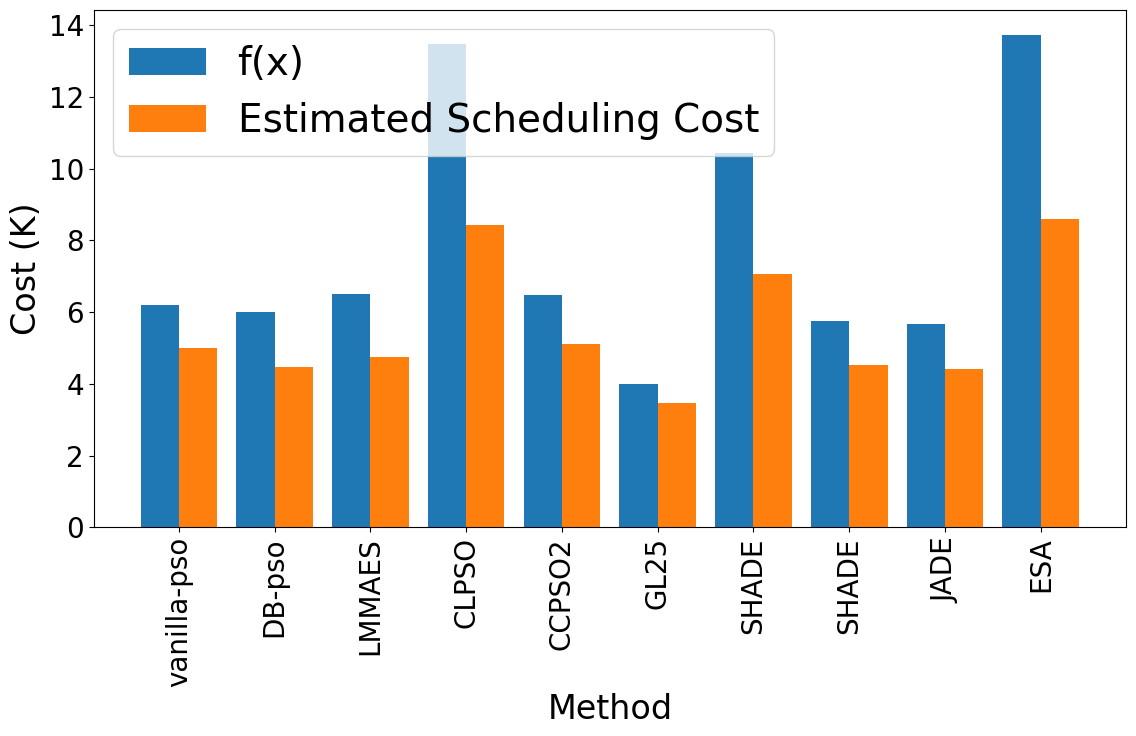

In [55]:

fig,ax = plt.subplots(figsize=(12,8))

x = np.arange(len(estimated_objective))+1
estimated_objective_k = [x/1000 for x in estimated_objective]
makespans_k = [x/1000 for x in makespans]


ax.bar(x-0.2,estimated_objective_k,label='f(x)',width=0.4)
ax.bar(x+0.2,makespans_k,label='Estimated Scheduling Cost',width=0.4)

plt.xticks(x,algorithm_names,rotation=90)

ax.legend(loc='best')

ax.set_xlabel('Method')
ax.set_ylabel('Cost (K)')

fig.tight_layout()

In [56]:
print(algorithm_names)
print(makespans)
print(estimated_objective)

['vanilla-pso', 'DB-pso', 'LMMAES', 'CLPSO', 'CCPSO2', 'GL25', 'SHADE', 'SHADE', 'JADE', 'ESA']
[4999.059646834427, 4458.639978294757, 4755.714875142215, 8442.182575863293, 5123.795646055997, 3474.308012011775, 7067.21879573383, 4519.072719507922, 4427.7486018509135, 8585.321291320055]
[np.float64(6192.7764349752515), np.float64(6010.284411385389), 6516.107560115759, 13476.196502590983, 6490.121494425105, 4008.228248180561, 10441.324623192495, 5760.920992993265, 5677.61305619498, 13733.865926569231]


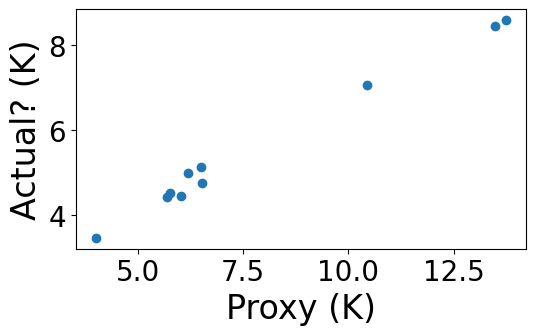

In [59]:

fig,ax = plt.subplots(figsize=(6,4))

estimated_objective_k = [x/1000 for x in estimated_objective]
makespans_k = [x/1000 for x in makespans]

ax.scatter(estimated_objective_k,makespans_k)

ax.set_xlabel('Proxy (K)')
ax.set_ylabel('Actual? (K)')

fig.tight_layout()